In [1]:
import re
import itertools
from __future__ import print_function
import pandas as pd
import datetime as dt
import numpy as np
import nltk
import string
import scipy.sparse as sparse
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-white')

re_spaces = re.compile(r'\s+')

from mpl_toolkits.mplot3d import axes3d
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

C:\Users\Shivi\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\Shivi\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def cleaned_reviews(x):
    return(''.join(re.sub('[^a-zA-Z]', ' ', x).replace(':',' ').lower().strip().replace('\r',' ').replace('!',' ')))


In [3]:
import spacy
import en_core_web_sm

nlp = en_core_web_sm.load()

In [380]:
def noun_chunk(sentence):
    nlp = en_core_web_sm.load()
    doc = nlp(sentence)
    for t in doc:
        if t.pos_ == 'NOUN':
            noun_token = [t for t in doc if t.pos_ == 'NOUN'][0]
            if noun_token.children.pos_ == 'ADJ':
                adj_token = [t for t in noun_token.children if t.pos_ == 'ADJ'][0]        
                word = adj_token.text + '_' + noun_token.text
                sentence = sentence.replace(adj_token.text,'').replace(noun_token.text, word)
            else:
                sentence = sentence
    
    return sentence

# Reading File in Pandas

In [433]:
table_data = pd.read_json('review_scraper.json')

In [434]:
del table_data['index']

Modifying file for Data Visualization

In [435]:
df2 = table_data.copy()

In [436]:
df2['Year'] = df2['Date'].dt.year

In [437]:
df2 = df2[df2['Year']>=2017]

In [438]:
df2['Ratings'] = df2['Ratings'].apply(lambda x: x.split()[0]).apply(lambda x: pd.to_numeric(x))

In [439]:
df2['Comments'] = df2['Comments'].apply(lambda x: x.replace('Was this review helpful to you?',''))

In [440]:
df2['Comments'].replace('', np.nan, inplace=True)

In [441]:
#df_comment.dropna(subset=['Comments'], inplace=True)

In [442]:
df2['Comments'].replace(np.nan, '0', inplace=True)

In [443]:
df2['Comments'] = df2['Comments'].apply(lambda x: x.split()[0].replace('One','1'))

In [444]:
df2['Comments'] = df2['Comments'].apply(lambda x: pd.to_numeric(x))

In [445]:
#df2.sort_index()

In [446]:
df2['Length_Reviews'] = df2['Reviews'].apply(lambda x : len(x))

In [447]:
df2['Length_Title'] = df2['Title'].apply(lambda x : len(x))

In [448]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 841 entries, 0 to 99
Data columns (total 9 columns):
Author            841 non-null object
Comments          841 non-null int64
Date              841 non-null datetime64[ns]
Ratings           841 non-null float64
Reviews           841 non-null object
Title             841 non-null object
Year              841 non-null int64
Length_Reviews    841 non-null int64
Length_Title      841 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 65.7+ KB


In [449]:
df2['Reviews'] = df2['Reviews'].apply(lambda x: cleaned_reviews(x))

In [450]:
#df2['Reviews']

In [451]:
df2['Title'] = df2['Title'].apply(lambda x: cleaned_reviews(x))

In [452]:
#df2['Title']

In [453]:
df2['Auth_Cat'] = df2['Author'].apply(lambda x : 'Amazon_Cust' if x == 'Amazon Customer' else 'Others')

In [454]:
#df2

# Exploratory Data Analysis

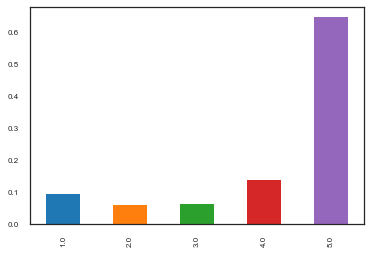

In [388]:
(df2['Ratings'].value_counts()/len(df2)).sort_index().plot.bar()

60+% of verified customer gave 5 stars to the product.Around 15% gave 4 stars and rest(15%) gave less than 3. That implies product features have really positive customer satisfaction.

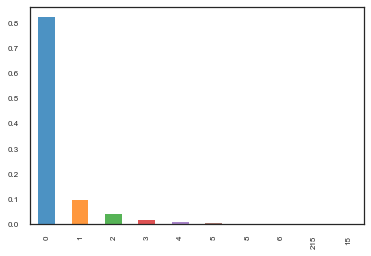

In [389]:
(df2['Comments'].value_counts()/len(df2)).plot.bar(alpha = 0.8)

In [390]:
def helpfulness_section(x):
        if x == 0:
            return 'No Indication'
        elif x < 3:
            return 'Unhelpful'
        elif x < 10:
            return 'Helpful'
        elif x > 10:
            return 'Very Helpful'

In [391]:
df2['Comment_section'] = df2['Comments'].apply(lambda x: pd.to_numeric(x)).apply(lambda x: helpfulness_section(x))

Text(0.5,1,'Relative Proportion of Helpfulness')

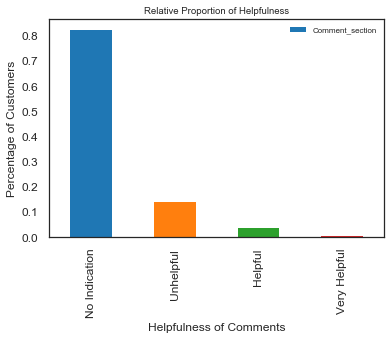

In [392]:
ax = (df2['Comment_section'].value_counts()/len(df2)).plot(kind='bar', title ="V comp",legend=True, fontsize=12)
ax.set_xlabel("Helpfulness of Comments",fontsize=12)
ax.set_ylabel("Percentage of Customers",fontsize=12)
ax.set_title('Relative Proportion of Helpfulness')

Most of the reviews( approx 80+) are not helpful to customers. 15% reviews found helpful to less customers, and only few reviews are helpful.But exceptionally 1 review found helpful to 215 customers(may be outliers)

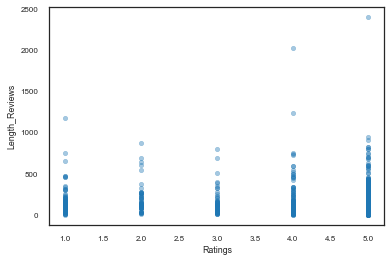

In [393]:
df2.plot(kind="scatter", x="Ratings", y="Length_Reviews", alpha=0.4)

Clearly visible that reviewers give lengthy reviews if they are highly satisfied/dissatisfied (1/4-5 stars). Nuetral reviewers do not comment much.

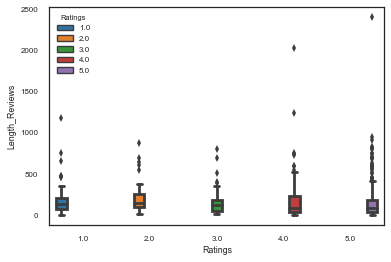

In [394]:
sns.set_context('poster',font_scale=0.5)
sns.boxplot(x="Ratings", y="Length_Reviews", hue="Ratings", data=df2)
plt.figure(figsize=(10,6)) 

5-star reviews had the lowest median word count (apx 70-80 words),
while 2-star reviews had the largest median word count (apx 100 words).
Exceptional(max) word count observed in 5 star review.
Implies customer lengthy reviews when highly disatisfied

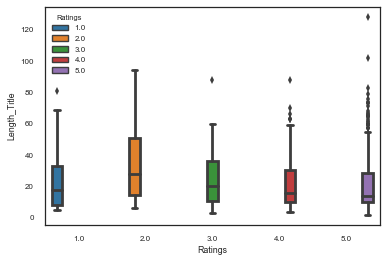

In [395]:
sns.set_context('poster',font_scale=.5)
sns.boxplot(x="Ratings", y="Length_Title", hue="Ratings", data=df2)
plt.figure(figsize=(10,6)) 

5-star reviews had the lowest median word count (apx 15 words),
while 2-star reviews had the largest median word count (apx 30 words).
Exceptional(max) word count observed in 5 star review.

In [396]:
'''fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])
axes.plot(df2['Ratings'], df2['Comments'],'b')
axes.set_xlabel('Ratings') # Notice the use of set_ to begin methods
axes.set_ylabel('Helpfulness_Level')
axes.set_title('Stars effects on Helpfulness')'''

"fig = plt.figure()\naxes = fig.add_axes([0.1, 0.1, 0.8, 0.8])\naxes.plot(df2['Ratings'], df2['Comments'],'b')\naxes.set_xlabel('Ratings') # Notice the use of set_ to begin methods\naxes.set_ylabel('Helpfulness_Level')\naxes.set_title('Stars effects on Helpfulness')"

Not a useful graph. 

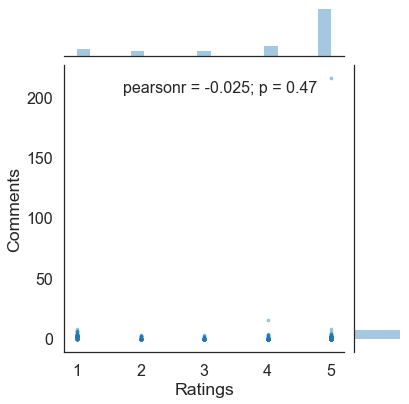

In [397]:
sns.set_context('poster',font_scale=1)
sns.jointplot(x='Ratings',y='Comments',data=df2,kind='scatter', alpha = 0.4, s = 10)
plt.figure(figsize=(10,6)) 

The helpful reviews are high for extreme stars 1 or 5, may be co-related to length of reviews.

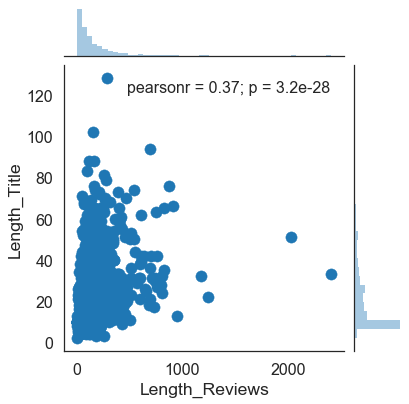

In [398]:
sns.set_context('poster',font_scale=1)
sns.jointplot(x='Length_Reviews',y='Length_Title',data=df2,kind='scatter')
plt.figure(figsize=(10,6)) 

Nuetral to Positively corelated , reviewers with lengthy title tends to do descriptive reviewing 

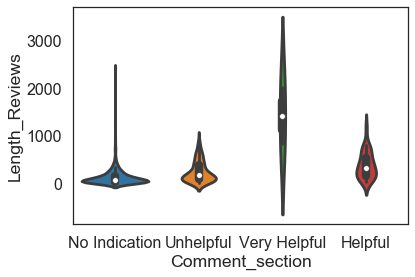

In [399]:
sns.violinplot(x='Comment_section', y='Length_Reviews', data=df2, alpha = 0.2, s= 10)
plt.figure(figsize = (10,6))

The word counts for helpful reviews and No indication reviews is bit more than unhelpful.
The greatest concentration of reviews of approximately 1500 words. 
However, unhelpful reviews have a larger concentration of reviews with 
low word count and helpful reviews have more longer reviews. Helpful reviews have a higher 
median word count (200 words) than unhelpful reviews (100 words).
The comment with max word count(aprx 1500) has highest concentration of helpfulness.

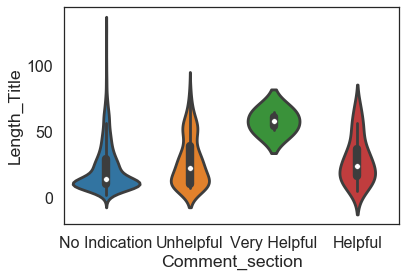

In [400]:
sns.violinplot(x='Comment_section', y='Length_Title', data=df2)

Most useful reviews have lenghy elaborative titles.

# Classification based on Neg/Pos Reviews

In [455]:
df1 = df2.copy()

In [456]:
df = df1.loc[:, ['Reviews','Ratings', 'Title']]

In [457]:
df.shape

(841, 3)

In [458]:
df['Score'] = df['Ratings'].apply(lambda x : pd.to_numeric(x)).apply(lambda x : 'pos' if x > 3 else 'neg')

In [459]:
df = df.drop(['Ratings'], axis = 1)

Distribution of labels in the dataset

In [460]:
df.groupby('Score')['Reviews'].count()

Score
neg    183
pos    658
Name: Reviews, dtype: int64

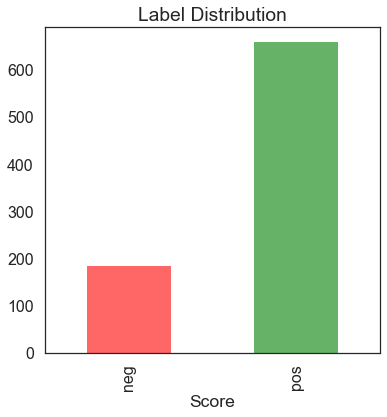

In [461]:
df.groupby('Score')['Reviews'].count().plot(kind='bar',color=['r','g'],title='Label Distribution',figsize=(6,6), alpha = 0.6)

As we can see the data is pretty skewed. We are able to already decide that we must use Stratified Split for evaluation

In [462]:
print ('Percentage of negative reviews %.2f %%' % ((df.groupby('Score')['Reviews'].count()['neg'])*100.0/len(df)))
print ('Percentage of positive reviews %.2f %%' % ((df.groupby('Score')['Reviews'].count()['pos'])*100.0/len(df)))

Percentage of negative reviews 21.76 %
Percentage of positive reviews 78.24 %


# Splitting the dataset based on labels

In [463]:
def splitPosNeg(Reviews):
    neg = df.loc[Reviews['Score']=='neg']
    pos = df.loc[Reviews['Score']=='pos']
    return [pos,neg]

In [464]:
[pos,neg] = splitPosNeg(df)

Tokenizing the training data to find frequency of words

In [465]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shivi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shivi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [466]:
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
translation = str.maketrans(string.punctuation,' '*len(string.punctuation))

def preprocessing(line):
    tokens=[]
    line = line.translate(translation)
    line = nltk.word_tokenize(line.lower())
    for t in line:
        #if(t not in stop):
            #stemmed = stemmer.stem(t)
        stemmed = lemmatizer.lemmatize(t)
        tokens.append(stemmed)
    return ' '.join(tokens)

In [467]:
pos_data = []
neg_data = []
for p in pos['Reviews']:
    pos_data.append(preprocessing(p))
for n in neg['Reviews']:
    neg_data.append(preprocessing(n))

In [468]:
stopword = ['a','for','in','i','it','these','flashlight', 'light','they','have','this','are','the','and','to','my','you','so','of','by','with','is','on','that','be']
pos_list = []
for line in pos_data:
    pword = nltk.word_tokenize(line)
    for p in pword:
        p = [x for x in pword if x not in stopword]
    pos_list.append(p)

positive =[]
for pword in pos_list:
    for p in pword:
        positive.append(p)
        
word_features_pos = nltk.FreqDist(positive)
print ('postive words:' + str(len(word_features_pos)))

postive words:1823


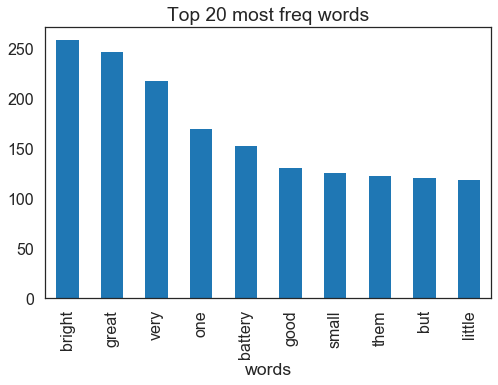

In [469]:
word_his = pd.DataFrame(word_features_pos.most_common(10),columns=['words','count'])
word_his.plot(kind='bar',x=word_his['words'],legend=False,title='Top 20 most freq words',figsize=((8,5)))

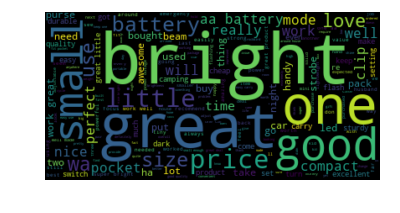

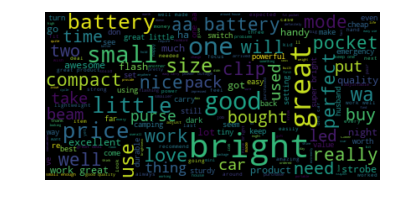

In [416]:
import os
from os import path
from wordcloud import WordCloud

# Read the whole text.
file1 = open("pos_word.txt","r")
text = file1.read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [417]:
stopword1 = ['a','bright','for','in','i','it','these','flashlight', 'light','they','have','this','are','the','and','to','my','you','so','of','by','with','is','on','that','be']
neg_list = []
for line in neg_data:
    nword = nltk.word_tokenize(line)
    for n in nword:
        n = [x for x in nword if x not in stopword1]
    neg_list.append(n)
    
negative =[]
for nword in neg_list:
    for n in nword:
        negative.append(n)

word_features_neg = nltk.FreqDist(negative)
print ('negative words:' + str(len(word_features_neg)))

negative words:1073


In [419]:
word_his_neg = pd.DataFrame(word_features_neg.most_common(10),columns=['words','count'])
word_his_neg.plot(kind='bar',x=word_his_neg['words'],legend=False,title='Top 20 most freq words',figsize=((8,5)))

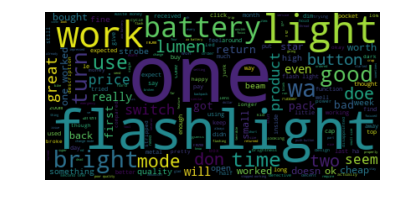

In [483]:
import os
from os import path
from wordcloud import WordCloud

# Read the whole text.
file2 = open("neg_word.txt","r")
text = file2.read()

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

We can see that the number of unique words in the dataset is pretty huge. 
When doing text classification the vocabulary of the data set becomes the featureset.

# Pre-Processing

In [421]:
stop_words = {'flash', 'light', 'flashlight', 'pron'}
class PartOfSpeechFilter(BaseEstimator, TransformerMixin):
    def __init__(self, pos_to_keep=('NOUN', 'ADJ'), stop_words=None):
        self.pos_to_keep = pos_to_keep
        self.stop_words = stop_words
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        preprocessed_sentences = []
        
        for doc in nlp.pipe(X, n_threads=8):
            if self.stop_words is not None:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep and t.lemma_ not in self.stop_words])
            else:
                keep_tokens_string = ' '.join([t.lemma_ for t in doc if t.pos_ in self.pos_to_keep])
            preprocessed_sentences.append(keep_tokens_string)
    
        return preprocessed_sentences 

# Splitting the data into train and test using a stratified strategy

In [470]:
data_review = df['Reviews']
labels = df['Score']

In [471]:
data_title = df['Title']
labels_1 = df['Score']

In [472]:
from sklearn.model_selection import train_test_split
[Data_train,Data_test,Train_labels,Test_labels] = train_test_split(data_review,labels, test_size=0.20, random_state=101,stratify=labels)
print(len(Data_train), "train +", len(Data_test), "test")

672 train + 169 test


In [473]:
from sklearn.model_selection import train_test_split
[Data_train_1,Data_test_1,Train_labels_1,Test_labels_1] = train_test_split(data_title,labels, test_size=0.20, random_state=101,stratify=labels)
print(len(Data_train_1), "train +", len(Data_test_1), "test")

672 train + 169 test


# Creating Pipeline - Model 1

In [474]:
from imblearn.pipeline import Pipeline
text_clf = Pipeline([('posf', PartOfSpeechFilter(stop_words={'flash', 'light', 'flashlight', 'pron'})),
                     ('cv', CountVectorizer(lowercase=True, stop_words='english',ngram_range = (1, 2), analyzer = 'word')),
                     ('tfidf', TfidfTransformer(norm = 'l2',use_idf=True)),
                     #('sm' , SMOTE(random_state=101)),
                     ('ad', ADASYN(ratio='minority',n_neighbors=5,random_state=101)),
                     #('svd', TruncatedSVD(random_state=101)),
                     #('knn', KNN())]),
                     #('lr', LogisticRegression())])
                     #('nb', GaussianNB())])
                     #('lda', LinearDiscriminantAnalysis())])
                     #('KNN', KNeighborsClassifier())])
                     #('CART', DecisionTreeClassifier())])
                     ('clf', MultinomialNB(alpha=1.0))])
                     #('svm', SVC(C=1.0,kernel='linear',random_state=101))])
                     #('sgd', SGDClassifier(random_state=101))])
                     #('rfc', RandomForestClassifier(random_state=101))])
                     #('BernoulliNB', BernoulliNB())])
                     #('Logistic' , linear_model.LogisticRegression(C=1e5))])
                     #('Decision Tree' , DecisionTreeClassifier(random_state=101, criterion='entropy'))])
                     #('Perceptron', linear_model.Perceptron(n_iter=1000))])

In [428]:
parameters = {
    #'cv__max_df': (1.0),
    #'cv__max_features': (100),
    'cv__ngram_range': (1, 2),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1','l2'),
    'clf__alpha': (0.00001,0.0000001),
    #'clf__penalty': ('l2','l1'),
    #'clf__n_iter': (10, 50, 80),
}

# Training the model

In [243]:
#grid_search = GridSearchCV(text_clf, parameters, n_jobs=-1, verbose=1)

In [244]:
#grid_search.fit(Data_train, Train_labels)

In [475]:
text_clf.fit(Data_train, Train_labels)

Pipeline(memory=None,
     steps=[('posf', PartOfSpeechFilter(pos_to_keep=('NOUN', 'ADJ'),
          stop_words={'flash', 'pron', 'light', 'flashlight'})), ('cv', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True..._state=101, ratio='minority')), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

# Evaluating the model

In [476]:
predicted = text_clf.predict(Data_test)
np.mean(predicted == Test_labels)

0.86390532544378695

CONFUSION MATRIX

In [477]:
conf_matrix = confusion_matrix(Test_labels, text_clf.predict(Data_test))
conf_matrix

array([[ 22,  15],
       [  8, 124]], dtype=int64)

In [478]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

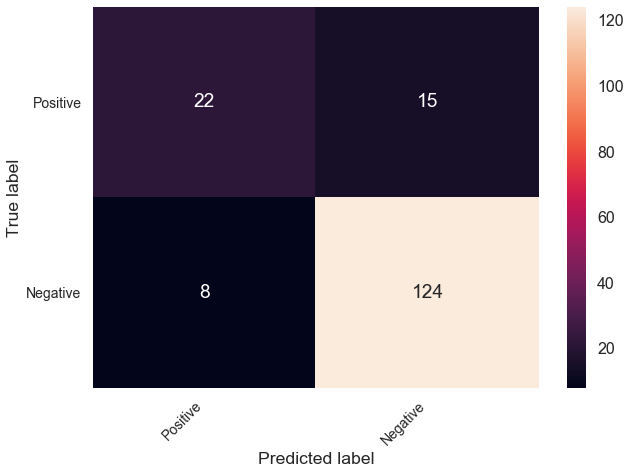

In [479]:
print_confusion_matrix(conf_matrix, ['Positive', 'Negative'])

# MODEL 2

In [573]:
from imblearn.pipeline import Pipeline
text_clf_title = Pipeline([('posf', PartOfSpeechFilter(stop_words={'flash', 'light', 'flashlight', 'pron'})),
                     ('cv', CountVectorizer(lowercase=True, stop_words='english',ngram_range = (1, 2), analyzer = 'word')),
                     ('tfidf', TfidfTransformer(use_idf=True)),
                     ('sm' , SMOTE(random_state=101)),
                     #('ad', ADASYN(random_state=101)),
                     #('svd', TruncatedSVD(random_state=101)),
                     #('knn', KNN())])
                     #('lr', LogisticRegression())])
                     #('nb', GaussianNB())])
                     #('lda', LinearDiscriminantAnalysis())])
                     #('KNN', KNeighborsClassifier())])
                     #('CART', DecisionTreeClassifier())])
                     ('clf', MultinomialNB(alpha=1))])
                     #('svm', SVC(C=1.0,kernel='linear',random_state=101))])
                     #('sgd', SGDClassifier(random_state=101))])
                     #('rfc', RandomForestClassifier(random_state=101))])
                     #('BernoulliNB', BernoulliNB())])
                     #('Logistic' , linear_model.LogisticRegression(C=1e5))])
                     #('Decision Tree' , DecisionTreeClassifier(random_state=101, criterion='entropy'))])
                     #('Perceptron', linear_model.Perceptron(n_iter=10))])

Evaluating Model

In [574]:
text_clf_title.fit(Data_train_1, Train_labels_1)
predicted = text_clf_title.predict(Data_test_1)
np.mean(predicted == Test_labels_1)

0.82840236686390534